In [1]:
# imports
import scipy.io
import numpy as np               # for arrays
from numpy import linalg as LA   # for eigenvalues
import matplotlib                # for plots
import time                      # for time measurements
from PIL import Image            # for showing images
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sympy
from functions import *

In [2]:
def show_img(img):
    temp = img.copy()
    temp.resize((46,56))
    im = Image.fromarray(temp.T)
    im.show()

Get training/test splits

In [3]:
# load data
mat = scipy.io.loadmat('face.mat')
raw_data = mat['X']

raw_data = np.transpose(raw_data)
N,D = raw_data.shape
C = 52 # number of classes in dataset
train_size = int(N * 0.8)
test_size = int(N * 0.2)

pca_training_data = np.empty([int(520*0.8), 2576])
pca_testing_data = np.empty([int(520*0.2), 2576])
lda_training_data = []
lda_testing_data = []

# create training and test data
for x in range(52):
    # 8/2 ratio for training and testing datasets
    lda_training_data.append(raw_data[x*10:x*10+8].copy())
    lda_testing_data.append(raw_data[x*10+8:(x+1)*10].copy())
    

lda_training_data = np.array(lda_training_data)
lda_testing_data = np.array(lda_testing_data)
pca_training_data = lda_training_data.reshape(train_size, D)
pca_testing_data = lda_testing_data.reshape(test_size,D)


We need to make sure that the generalised eigenvalue problem that we encounter when doing LDA is solvable by making sure that the within-class scatter matrix is non-singular.
We do this by first reducing the dimension of the data via low dim PCA to an M <= N - c.

In [149]:
def get_Wpca(data, out_dim,random, M0, M1):
    # low-dim PCA
    S = data.dot(data.T)
    w, v = LA.eigh(S)
    u = data.T.dot(v)
    u = u.T # the eigenvectors aren't normalised after this
    u /= LA.norm(u, ord=2, axis=0)
    
    # sort wrt abs(eigenvalue)
    id = np.argsort(np.abs(w))[::-1]
    w = w[id]
    u = u[id]
    if random == True:
        origin = u[:M0].copy()
        remaining = u[M0:].copy()
        random_features = remaining[np.random.choice(remaining.shape[0], M1, replace=False), :]
        new_u = np.concatenate((origin,random_features), axis=0)
        print(new_u.T)
        return new_u.T
        
        
    else:
        print(u[0:out_dim].T.shape)
        return u[0:out_dim].T
    

In [150]:
yo = get_Wpca(pca_training_data, 400, True, 50, 50)

[[ 9.31660052e-01 -3.22901718e-02 -1.22625745e-02 ...  1.96105618e-02
  -6.95036311e-03  2.21843495e-02]
 [ 9.31340889e-01 -3.56428875e-02 -1.74556041e-02 ...  2.26882730e-02
  -8.87043529e-03  2.39239851e-02]
 [ 9.28619689e-01 -3.53733064e-02 -2.01464804e-02 ...  2.06266492e-02
  -1.76749052e-02  1.91217162e-02]
 ...
 [ 8.48234530e-01 -1.99396767e-02 -1.24037726e-02 ...  1.55932243e-02
   2.72845764e-03 -1.83387634e-02]
 [ 8.42107495e-01 -1.33790348e-02 -1.81223296e-02 ...  7.47743902e-03
   1.32605676e-04 -2.59047278e-02]
 [ 8.35037189e-01 -1.23124376e-02 -1.81815847e-02 ... -3.76874167e-04
   1.12972372e-03 -2.80292349e-02]]


We want a projection that maximises the ratio between the between-class scatter matrix and the within class scatter matrix.
The projection W turns out to be the solutions to the generalised eigen value problem. (Found via solving the langrangian. Slide 10-11)

In [5]:
def get_Wlda(Sb_data, Sw_data, out_dim):
    #code that gets value
    lda_evals, lda_evecs = LA.eig(LA.inv(Sw_data).dot(Sb_data))
    # print("magnitud of eigenvecs: ", LA.norm(lda_evecs.T[0], ord=2, axis=0))
    lda_evecs = lda_evecs.T
#     print("lda_evals: ", lda_evals)
    
    # sort wrt abs(eigenvalue)
    id = np.argsort(np.abs(lda_evals))[::-1]
    lda_evals = lda_evals[id]
    lda_evecs = lda_evecs[id]
    return lda_evecs[0:out_dim].T

In [154]:
def get_Wopt(pca_data, lda_data, Mpca, Mlda, random=False, M0=46, M1=200, committee_size=2):
    # random is true, returns tensor of random Wopts
    mean_all_data = pca_data.T.mean(axis=1).T

    # between class scatter (scalar)
    mean_class_data = lda_data.mean(axis=1)
    diff_class_mean = mean_class_data - mean_all_data
    Sb = np.dot(diff_class_mean.T, diff_class_mean)
    Sb *= np.array([8])

    # within class scatter (scalar)
    diff_class_data = lda_data - mean_class_data.reshape(52,1,-1)
    Sw = np.zeros((2576, 2576));
    for x in diff_class_data:
        Sw += np.dot(x.T,x)
    #use
    new_ensemble = np.empty([committee_size, 2576, M0 + M1])
    for x in range(committee_size):
        Wpca = get_Wpca(pca_data, Mpca, True, M0, M1)
        reduced_Sb = Wpca.T.dot(Sb).dot(Wpca) # symmetric matrix hopefully
        reduced_Sw = Wpca.T.dot(Sw).dot(Wpca)
        Wlda = get_Wlda(reduced_Sb, reduced_Sw, Mlda)

        Wopt = Wlda.T.dot(Wpca.T).T
        Wopt /= LA.norm(Wopt, ord=2, axis=1, keepdims=True)
        new_ensemble[x] = Wopt
        
#     print("Wopt: ", Wopt.shape, " Wlda.T: ", Wlda.T.shape, " Wpca.T ", Wpca.T.shape)
    
    return new_ensemble

We can now express each data point as product of a weight vector with Wopt. This weight vector can be used to classify each data point using nearest neighbour

In [155]:
def get_PCALDA_accuracy(Mpca, Mlda,random=False, M0=46, M1=200, committee_size=2):
    
    W = get_Wopt(pca_training_data, lda_training_data, Mpca, Mlda, random, M0, M1, committee_size)
    print("reached here")
    
    training_face_weights = np.matmul(np.transpose(W,(0,2,1)),pca_training_data.T)
    testing_face_weights = np.matmul(np.transpose(W,(0,2,1)),pca_testing_data.T)
    print("got here")
    
    result = class_rate(training_face_weights.T.real, testing_face_weights.T.real)
    acc = 100*np.sum(result, axis=-1)/len(result)
    print("Mpca: ", Mpca, " Mlda: ", Mlda, " Classification rate: ", acc, "%.")
    return acc


In [31]:
percent = get_PCALDA_accuracy(46,12)
print(percent)

Wopt:  (2576, 12)  Wlda.T:  (12, 46)  Wpca.T  (46, 2576)
Mpca:  46  Mlda:  12  Classification rate:  80.76923076923077 %.
80.76923076923077


Now lets test the accuracy of the classifier as we vary Mpca from 1 to 416 and keeping LDA at 416. 
When the dimensions D is larger than the number of data points, the within-class covariance matrix becomes singular and so cannot be inverted. Therefore, PCA is used on the data before LDA in order to reduce the dimensions of the data and make Sw non-singular.

Another reason is that having an Mpca too high is known to make the model overfit. This is because when the dimension of data is much larger than the number of data points, finding a linear projection into a lower dimension that separates the classes completely becomes very easy and the projection found often does not generalise well. In this light, PCA can be seen as a regularisation technique.

https://stats.stackexchange.com/questions/106121/does-it-make-sense-to-combine-pca-and-lda

For this dataset, the best regularisation is Mpca = 46

In [9]:
# results = []
# for i in range(1, 417):
#     results.append(get_PCALDA_accuracy(i, 417))


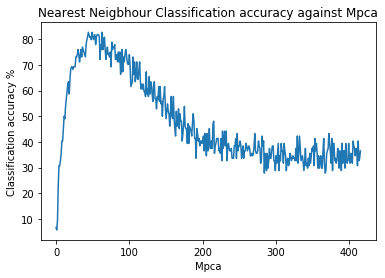

In [10]:
results = np.loadtxt("VaryingPca.txt")
plot_data("Nearest Neigbhour Classification accuracy against Mpca", "Mpca", "Classification accuracy %", results)
# plt.savefig("Vary_Mpca_NN.png")
# np.savetxt("VaryingPca.txt", results)
# this graph shows that the test accuracy initially increases as Mpca increases as the model is given more 
# information to work with. Maximum accuracy is reached when Mpca is at 46. When Mpca increases above 46, 
# the model overfits and test accuracy decreases. This problem can be solved by using more data samples.


In [11]:
# ldaresults = []
# for i in range(1, 417):
#     ldaresults.append(get_PCALDA_accuracy(47, i))


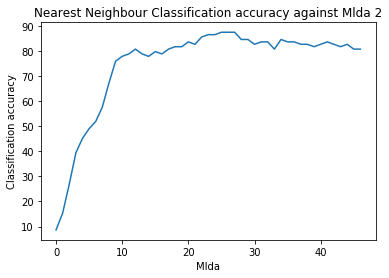

In [19]:
ldaresults = np.loadtxt("VaryingLda.txt")
ldaresults2 = ldaresults[0:47]
plot_data("Nearest Neighbour Classification accuracy against Mlda 2","Mlda","Classification accuracy", ldaresults2)
# np.savetxt("VaryingLda.txt", ldaresults)
# this graph shows that only the first 50 largest eigenvalues from LDA give discriminate between the different classes
# the smallest eigenvalues are too small or zero

Ensembles aim to create stronger classifiers by fusing the predictions of multiple weaker classifiers in the hope that their individual strengths cover different areas of the input space or that the weak experts reinforce each others decisions. The weak classifiers in an ensemble can be created by either randomly sampling in feature space or by training on random subsets of the data set. There output is then fused by a fusion rule, the type of fusion rule chosen affects that overall performance of the model

First do pca, then do LDA on a random subset of those principal components
get their individual classifications 
get their combined classification using some fusion rule - READ UP
start decimating models randomly, down to 1 model to see how the number of models affects output score

Get random samples of data sets create samples randomly and then classify each data set in series
keep their models and run them individually on the whole dataset
combine their outputs using some fusion rule
decimate models randomly like above

try different fusion rules for each different model number

the effect of different fusion rules on a committee machines composed of varying number of weaker machines

Vary randomness parametre





In [156]:
ensemble_results = get_PCALDA_accuracy(416, 416, random=True)

[[ 9.31660052e-01 -3.22901718e-02 -1.22625745e-02 ...  2.10120162e-02
  -2.49457031e-03  9.08402299e-04]
 [ 9.31340889e-01 -3.56428875e-02 -1.74556041e-02 ...  2.15498614e-02
   8.38363156e-03 -2.54950268e-03]
 [ 9.28619689e-01 -3.53733064e-02 -2.01464804e-02 ...  1.72556866e-02
   1.23565648e-02 -4.51040892e-04]
 ...
 [ 8.48234530e-01 -1.99396767e-02 -1.24037726e-02 ...  6.49767223e-03
  -2.51964401e-02 -2.86517076e-03]
 [ 8.42107495e-01 -1.33790348e-02 -1.81223296e-02 ...  1.71444123e-02
  -2.97610510e-02  2.01966439e-03]
 [ 8.35037189e-01 -1.23124376e-02 -1.81815847e-02 ...  1.47237941e-02
  -3.07668101e-02  8.24854498e-03]]


/home/jmw16/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


[[ 0.93166005 -0.03229017 -0.01226257 ...  0.01506729  0.00283187
   0.01334974]
 [ 0.93134089 -0.03564289 -0.0174556  ...  0.00753366  0.01772233
   0.01417849]
 [ 0.92861969 -0.03537331 -0.02014648 ...  0.01488951  0.02633206
   0.0217727 ]
 ...
 [ 0.84823453 -0.01993968 -0.01240377 ... -0.01326816 -0.02152531
   0.01936201]
 [ 0.8421075  -0.01337903 -0.01812233 ... -0.01615289 -0.03834446
   0.01955922]
 [ 0.83503719 -0.01231244 -0.01818158 ...  0.00138556 -0.02761683
   0.01727561]]
reached here
got here


ValueError: Found array with dim 3. Estimator expected <= 2.